# **Flight Price Prediction Dataset - Part 2**

# Step 1: Error Analysis Conclusions & work plan

### Key Findings
1. Overall Model Performance:
  * Average prediction error is 13.83%.
  * Model tends to overestimate (52.9%) slightly more than underestimate (47.1%)

2. Challenges in Predicting Specific Flight Scenarios:

  Our initial error analysis approach raised a methodological concern: we analyzed absolute errors (MAE) without considering the relative price levels. However, after examining the price distributions across different features, we can draw meaningful conclusions about the model's performance. The model shows consistently higher prediction errors in certain scenarios that cannot be explained by base price differences alone: multi-stop flights show significantly larger errors compared to non-stop flights, despite relatively modest price differences between these categories. Similarly, while Jet Airways flights don't have notably higher prices than other carriers, the model struggles more with predicting their prices accurately. For flight duration, longer flights show higher prediction errors that cannot be fully explained by price variations alone, as the relationship between duration and price isn't strongly linear. These patterns suggest genuine challenges in the model's ability to handle these specific scenarios, rather than simply reflecting differences in base prices.

3. Clear difficulty with high-price tickets, evidenced by disproportionate increase in MAE.

  Note: While we expect MAE to naturally increase with price, the increase we observed in the highest quintile was dramatically larger than the proportional increases between other quintiles. This non-linear jump in error suggests a genuine weakness in handling high-price tickets, beyond what would be expected from price differences alone.

4. Feature Importance Analysis:
  * Most influential features:
    * Airline (especially Jet Airways Business and major carriers)
    * Duration_Hours
    * Total_Stops_2 stops showed high importance
  * Some categorical encodings showed zero importance:
    * Total_Stops_4 stops and Total_Stops_non-stop
    * Airline_Trujet
    * Various destination encodings

  This suggests that specific categories within our categorical variables are much more predictive than others, which could inform feature engineering strategy







### Work Plan
Based on the above observations, our plan includes:
1. Addressing outliers in price through IQR-based outlier removal.
2. Improving feature engineering to account for complex relationships in the data.
3. Reintroducing previously excluded features (`Route`, `Additional_Info`) to explore their potential contribution to the model. Specifically:
    - Analyze the `Route` feature to identify costly intermediate stops and extract route popularity.
    - Investigate the impact of `Additional_Info` by extracting meaningful categories from its text.
4. Ensure balanced test sets across price ranges.
5. Hyperparameter Tuning:
    - Use systematic methods such as grid search or randomized search to optimize parameters like `learning_rate`, `max_depth`, and `n_estimators`.
    - Focus on improving model generalization and reducing overfitting.

# Step 2: Improving Model Performance

## 0. Imports

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

# Modeling and evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, roc_auc_score
import xgboost as xgb

import scipy.stats as stats
from tabulate import tabulate

## 1. Loading The CSV Dataset And The Basic Model (X, y and the model)

In [ ]:
from google.colab import files
uploaded = files.upload()

Training Basic Model (without improvements) for Comparison:

In [ ]:
X_train_basic = pd.read_csv('X_train_basic.csv')
X_test_basic = pd.read_csv('X_test_basic.csv')
y_train_basic = pd.read_csv('y_train_basic.csv')
y_test_basic = pd.read_csv('y_test_basic.csv')

In [ ]:
y_train_basic = y_train_basic['Price']
y_test_basic = y_test_basic['Price']

In [ ]:
booster = xgb.Booster()
booster.load_model('basic_model.json')

model_basic = xgb.XGBRegressor()
model_basic._Booster = booster

In [ ]:
y_pred_basic = model_basic.predict(X_test_basic)

Loading the dataset:

In [ ]:
df = pd.read_csv('flight_data.csv')

In [ ]:
df.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR ? DEL,22:20,01:10,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU ? IXR ? BBI ? BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL ? LKO ? BOM ? COK,09:25,04:25,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU ? NAG ? BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR ? NAG ? DEL,16:50,21:35,4h 45m,1 stop,No info,13302


In [ ]:
df.describe()

,Price
count,10683.000000
mean,9087.064121
std,4611.359167
min,1759.000000
25%,5277.000000
50%,8372.000000
75%,12373.000000
max,79512.000000


## 2. Cleaning and Preprocessing

 ### Remove missing values in the dataset

In [ ]:
print("Missing values before imputation:")
print(df.isnull().sum())

Missing values before imputation:
Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              1
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        1
Additional_Info    0
Price              0
dtype: int64


In [ ]:
missing_route = df[df['Route'].isnull()]
print(missing_route)

        Airline Date_of_Journey Source Destination Route Dep_Time  \
9039  Air India       6/05/2019  Delhi      Cochin   NaN    09:45   

     Arrival_Time Duration Total_Stops Additional_Info  Price  
9039        09:25  23h 40m         NaN         No info   7480  


The two missing values are in the same row, so we will remove that row entirely.



In [ ]:
df = df.dropna()

### Remove duplicates in the dataset

In [ ]:
df.duplicated().sum()

222

In [ ]:
df = df.drop_duplicates()

### Basic data processing

In [ ]:
def duration_to_hours(duration):
    """Convert duration string to hours"""
    hours, minutes = 0, 0
    if 'h' in duration:
        hours = int(duration.split('h')[0])
    if 'm' in duration:
        minutes = int(duration.split(' ')[-1].replace('m', ''))
    return hours + minutes / 60

def convert_to_decimal_hour(time_str):
    """Convert time string to decimal hours"""
    if pd.isna(time_str):
        return None
    time_obj = pd.to_datetime(time_str, format='%H:%M').time()
    return time_obj.hour + time_obj.minute / 60

df_processed = df.copy()

# Convert Duration to hours
df_processed['Duration_Hours'] = df_processed['Duration'].apply(duration_to_hours)
df_processed.drop(['Duration'], axis=1, inplace=True)

# Convert departure and arrival times to decimal hours
df_processed['Dep_Hour'] = df_processed['Dep_Time'].apply(convert_to_decimal_hour)
df_processed['Arr_Hour'] = df_processed['Arrival_Time'].apply(convert_to_decimal_hour)
df_processed.drop(['Dep_Time', 'Arrival_Time'], axis=1, inplace=True)

# Process date
df_processed['Date_of_Journey'] = pd.to_datetime(df_processed['Date_of_Journey'], format='%d/%m/%Y')
df_processed['Journey_Day'] = df_processed['Date_of_Journey'].dt.day
df_processed['Journey_Month'] = df_processed['Date_of_Journey'].dt.month
df_processed['Journey_Weekday'] = df_processed['Date_of_Journey'].dt.weekday
df_processed.drop(['Date_of_Journey'], axis=1, inplace=True)

## 3. Feature Engineering

In [ ]:
def feature_engineering(df):
    """Create all engineered features"""
    df = df.copy()

    # 1. Time-based features
    df['Is_Night_Flight'] = (df['Dep_Hour'] < 6) | (df['Dep_Hour'] >= 20)
    df['Is_Peak_Hour'] = df['Dep_Hour'].between(7, 10) | df['Dep_Hour'].between(16, 19)
    df['Is_Weekend'] = df['Journey_Weekday'].isin([5, 6])

    # 2. Process Additional_Info
    def extract_additional_info(info):
        if pd.isna(info) or info == 'No info':
            return 'No info'
        elif 'check-in baggage' in info:
            return 'No check-in baggage'
        elif 'meal' in info:
            return 'No meal'
        else:
            return 'Other'

    if 'Additional_Info' in df.columns:
        df['Additional_Info_Category'] = df['Additional_Info'].apply(extract_additional_info)
        df = pd.get_dummies(df, columns=['Additional_Info_Category'], drop_first=True)
        df.drop('Additional_Info', axis=1, inplace=True)

    # 3. Process Route
    if 'Route' in df.columns:
        # Major metro cities in India that serve as important hubs
        metro_cities = {'DEL', 'BOM', 'BLR', 'HYD', 'CCU', 'MAA'}  # Delhi, Mumbai, Bangalore, Hyderabad, Kolkata, Chennai

        def count_metro_stops(route):
            if pd.isna(route):
                return 0

            cities = [city.strip() for city in route.replace('?', '').split()]
            # Remove source and destination
            intermediate_cities = set(cities[1:-1])

            # Count metro stops
            return len(intermediate_cities & metro_cities)

        # Add metro stops count
        df['Metro_Stops'] = df['Route'].apply(count_metro_stops)

        # Calculate route popularity
        route_counts = df['Route'].value_counts()
        df['Route_Frequency'] = df['Route'].map(route_counts)

    return df

In [ ]:
df_processed = feature_engineering(df_processed)

In [ ]:
df_processed.head()

,Airline,Source,Destination,Route,Total_Stops,Price,Duration_Hours,Dep_Hour,Arr_Hour,Journey_Day,Journey_Month,Journey_Weekday,Is_Night_Flight,Is_Peak_Hour,Is_Weekend,Additional_Info_Category_No info,Additional_Info_Category_No meal,Additional_Info_Category_Other,Metro_Stops,Route_Frequency
0,IndiGo,Banglore,New Delhi,BLR ? DEL,non-stop,3897,2.833333,22.333333,1.166667,24,3,6,True,False,True,True,False,False,0,1534
1,Air India,Kolkata,Banglore,CCU ? IXR ? BBI ? BLR,2 stops,7662,7.416667,5.833333,13.250000,1,5,2,True,False,False,True,False,False,0,6
2,Jet Airways,Delhi,Cochin,DEL ? LKO ? BOM ? COK,2 stops,13882,19.000000,9.416667,4.416667,9,6,6,False,True,True,True,False,False,1,41
3,IndiGo,Kolkata,Banglore,CCU ? NAG ? BLR,1 stop,6218,5.416667,18.083333,23.500000,12,5,6,False,True,True,True,False,False,0,9
4,IndiGo,Banglore,New Delhi,BLR ? NAG ? DEL,1 stop,13302,4.750000,16.833333,21.583333,1,3,4,False,True,False,True,False,False,0,3


## 4. One-Hot Encoding and Train-test split with balanced price ranges

In [ ]:
# 1. One-hot encoding for categorical variables
def encode_categorical_features(df):
    """Perform one-hot encoding for categorical variables"""
    df = df.copy()

    # Drop the Route column as we've already extracted its features
    if 'Route' in df.columns:
        df = df.drop('Route', axis=1)

    categorical_columns = ['Airline', 'Source', 'Destination', 'Total_Stops']

    # Apply one-hot encoding
    df = pd.get_dummies(df, columns=categorical_columns, drop_first=True)

    print("Shape after encoding:", df.shape)
    print("Features after encoding:", sorted(df.columns.tolist()))
    return df

# 2. Train-test split with balanced price ranges
def create_balanced_split(df, target_column='Price'):
    """Create a balanced train-test split based on price quintiles"""
    df['price_quintile'] = pd.qcut(df[target_column], q=5, labels=False)

    X = df.drop([target_column, 'price_quintile'], axis=1)
    y = df[target_column]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=0.2,
        random_state=42,
        stratify=df['price_quintile']
    )

    print("Training set shape:", X_train.shape)
    print("Test set shape:", X_test.shape)
    return X_train, X_test, y_train, y_test

In [ ]:
df_encoded = encode_categorical_features(df_processed)
X_train, X_test, y_train, y_test = create_balanced_split(df_encoded)

Shape after encoding: (10460, 39)
Features after encoding: ['Additional_Info_Category_No info', 'Additional_Info_Category_No meal', 'Additional_Info_Category_Other', 'Airline_Air India', 'Airline_GoAir', 'Airline_IndiGo', 'Airline_Jet Airways', 'Airline_Jet Airways Business', 'Airline_Multiple carriers', 'Airline_Multiple carriers Premium economy', 'Airline_SpiceJet', 'Airline_Trujet', 'Airline_Vistara', 'Airline_Vistara Premium economy', 'Arr_Hour', 'Dep_Hour', 'Destination_Cochin', 'Destination_Delhi', 'Destination_Hyderabad', 'Destination_Kolkata', 'Destination_New Delhi', 'Duration_Hours', 'Is_Night_Flight', 'Is_Peak_Hour', 'Is_Weekend', 'Journey_Day', 'Journey_Month', 'Journey_Weekday', 'Metro_Stops', 'Price', 'Route_Frequency', 'Source_Chennai', 'Source_Delhi', 'Source_Kolkata', 'Source_Mumbai', 'Total_Stops_2 stops', 'Total_Stops_3 stops', 'Total_Stops_4 stops', 'Total_Stops_non-stop']
Training set shape: (8368, 38)
Test set shape: (2092, 38)


In [ ]:
df_encoded.head()

,Price,Duration_Hours,Dep_Hour,Arr_Hour,Journey_Day,Journey_Month,Journey_Weekday,Is_Night_Flight,Is_Peak_Hour,Is_Weekend,...,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata,Destination_New Delhi,Total_Stops_2 stops,Total_Stops_3 stops,Total_Stops_4 stops,Total_Stops_non-stop,price_quintile
0,3897,2.833333,22.333333,1.166667,24,3,6,True,False,True,...,False,False,False,False,True,False,False,False,True,0
1,7662,7.416667,5.833333,13.250000,1,5,2,True,False,False,...,False,False,False,False,False,True,False,False,False,2
2,13882,19.000000,9.416667,4.416667,9,6,6,False,True,True,...,True,False,False,False,False,True,False,False,False,4
3,6218,5.416667,18.083333,23.500000,12,5,6,False,True,True,...,False,False,False,False,False,False,False,False,False,1
4,13302,4.750000,16.833333,21.583333,1,3,4,False,True,False,...,False,False,False,False,True,False,False,False,False,4


## 5. Handling Outliers

In [ ]:
def handle_outliers(X_train, X_test, y_train, y_test):
    # Calculate limits for the price
    Q1 = y_train.quantile(0.25)
    Q3 = y_train.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Mask for finding the correct observations
    mask_train = (y_train >= lower_bound) & (y_train <= upper_bound)

    # Removing outliers from the training set
    X_train_clean = X_train[mask_train]
    y_train_clean = y_train[mask_train]

    print(f"Removed {(~mask_train).sum()} outliers from training set")
    return X_train_clean, X_test, y_train_clean, y_test

In [ ]:
X_train, X_test, y_train, y_test = handle_outliers(X_train, X_test, y_train, y_test)

Removed 75 outliers from training set


## 6. Training the Model with Hyperparameter Tuning

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred):
    """Calculate Mean Absolute Percentage Error"""
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def evaluate_model(X_train, X_test, y_train, y_test, params):
    model = xgb.XGBRegressor(**params, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    return mape, model, y_pred

In [ ]:
# Define parameter combinations to try (adding more parameters)
parameter_combinations = [
    {'max_depth': 3, 'learning_rate': 0.01, 'n_estimators': 100, 'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 1, 'reg_alpha': 0.1, 'reg_lambda': 1},
    {'max_depth': 3, 'learning_rate': 0.1, 'n_estimators': 100, 'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 1, 'reg_alpha': 0.1, 'reg_lambda': 1},
    {'max_depth': 5, 'learning_rate': 0.01, 'n_estimators': 200, 'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 1, 'reg_alpha': 0.1, 'reg_lambda': 1},
    {'max_depth': 5, 'learning_rate': 0.1, 'n_estimators': 200, 'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 1, 'reg_alpha': 0.1, 'reg_lambda': 1},
    {'max_depth': 7, 'learning_rate': 0.01, 'n_estimators': 300, 'subsample': 0.9, 'colsample_bytree': 0.9, 'gamma': 1, 'reg_alpha': 0.1, 'reg_lambda': 1},
    {'max_depth': 7, 'learning_rate': 0.1, 'n_estimators': 300, 'subsample': 0.9, 'colsample_bytree': 0.9, 'gamma': 1, 'reg_alpha': 0.1, 'reg_lambda': 1},
    {'max_depth': 3, 'learning_rate': 0.05, 'n_estimators': 150, 'subsample': 0.85, 'colsample_bytree': 0.85, 'gamma': 1, 'reg_alpha': 0.05, 'reg_lambda': 1},
    {'max_depth': 3, 'learning_rate': 0.05, 'n_estimators': 250, 'subsample': 0.85, 'colsample_bytree': 0.85, 'gamma': 0.5, 'reg_alpha': 0.05, 'reg_lambda': 1},
    {'max_depth': 5, 'learning_rate': 0.05, 'n_estimators': 150, 'subsample': 0.85, 'colsample_bytree': 0.85, 'gamma': 0.5, 'reg_alpha': 0.05, 'reg_lambda': 1},
    {'max_depth': 5, 'learning_rate': 0.05, 'n_estimators': 250, 'subsample': 0.85, 'colsample_bytree': 0.85, 'gamma': 0.5, 'reg_alpha': 0.1, 'reg_lambda': 1},
    {'max_depth': 7, 'learning_rate': 0.05, 'n_estimators': 200, 'subsample': 0.9, 'colsample_bytree': 0.9, 'gamma': 0.5, 'reg_alpha': 0.1, 'reg_lambda': 1},
    {'max_depth': 7, 'learning_rate': 0.1, 'n_estimators': 400, 'subsample': 0.9, 'colsample_bytree': 0.9, 'gamma': 0.5, 'reg_alpha': 0.1, 'reg_lambda': 1},
]

In [ ]:
# Try each combination and store results
results = []
for params in parameter_combinations:
    mape, model, _ = evaluate_model(X_train, X_test, y_train, y_test, params)
    results.append({
        'parameters': params,
        'mape': mape
    })
    print(f"Parameters: {params}")
    print(f"MAPE: {mape:.2f}%\n")

Parameters: {'max_depth': 3, 'learning_rate': 0.01, 'n_estimators': 100, 'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 1, 'reg_alpha': 0.1, 'reg_lambda': 1}
MAPE: 30.12%

Parameters: {'max_depth': 3, 'learning_rate': 0.1, 'n_estimators': 100, 'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 1, 'reg_alpha': 0.1, 'reg_lambda': 1}
MAPE: 14.19%

Parameters: {'max_depth': 5, 'learning_rate': 0.01, 'n_estimators': 200, 'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 1, 'reg_alpha': 0.1, 'reg_lambda': 1}
MAPE: 18.07%

Parameters: {'max_depth': 5, 'learning_rate': 0.1, 'n_estimators': 200, 'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 1, 'reg_alpha': 0.1, 'reg_lambda': 1}
MAPE: 9.41%

Parameters: {'max_depth': 7, 'learning_rate': 0.01, 'n_estimators': 300, 'subsample': 0.9, 'colsample_bytree': 0.9, 'gamma': 1, 'reg_alpha': 0.1, 'reg_lambda': 1}
MAPE: 11.58%

Parameters: {'max_depth': 7, 'learning_rate': 0.1, 'n_estimators': 300, 'subsample': 0.9, 'colsample_bytree': 0.9, 'ga

In [ ]:
# Find best model
best_result = min(results, key=lambda x: x['mape'])
print("Best Parameters:", best_result['parameters'])
print(f"Best MAPE: {best_result['mape']:.2f}%")
print(f"Improvement from Part 1's MAPE (13.83%): {13.83 - best_result['mape']:.2f}%")

Best Parameters: {'max_depth': 7, 'learning_rate': 0.1, 'n_estimators': 400, 'subsample': 0.9, 'colsample_bytree': 0.9, 'gamma': 0.5, 'reg_alpha': 0.1, 'reg_lambda': 1}
Best MAPE: 7.03%
Improvement from Part 1's MAPE (13.83%): 6.80%


### Key Results from Model Improvement
Our hyperparameter tuning resulted in:
- **Best MAPE**: 7.03%
- **Improvement**: 6.80% (from Part 1's MAPE 13.83%)


# Step 3: Analyzing the Improved Model

## 1. Feature Importance Analysis

### XGBoost Feature Importance

In [ ]:
mape, best_model, y_pred_improved = evaluate_model(X_train, X_test, y_train, y_test, best_result['parameters'])

In [ ]:
residuals = y_test - y_pred_improved
rel_res=residuals/y_test
rel_res=rel_res.abs()

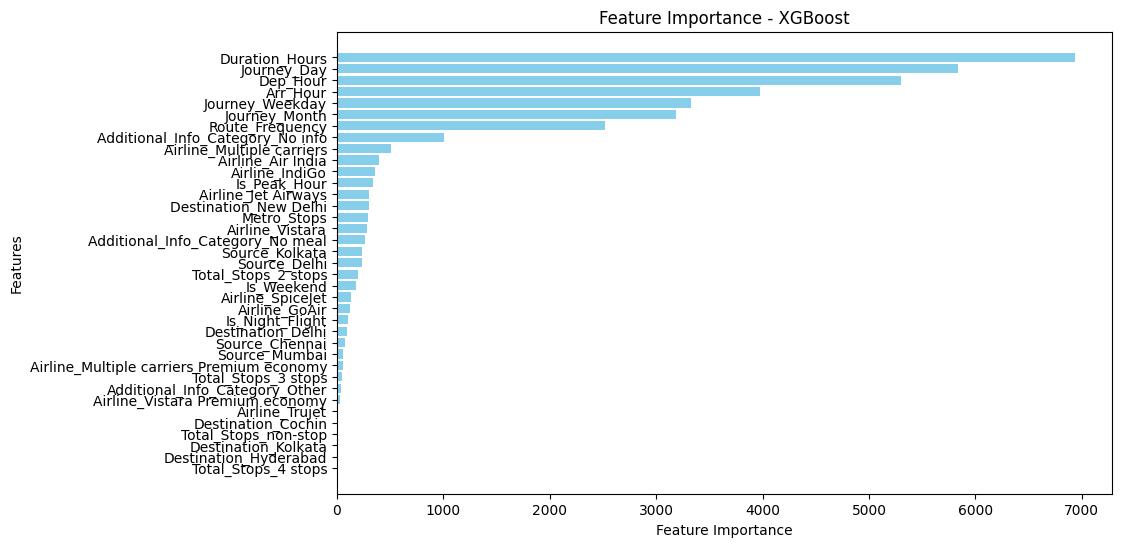

In [ ]:
importances = best_model.get_booster().get_score(importance_type='weight')

# Convert importance scores into a DataFrame for visualization
importance_df = pd.DataFrame.from_dict(importances, orient='index', columns=['Importance'])
importance_df.sort_values(by='Importance', ascending=False, inplace=True)

plt.figure(figsize=(10, 6))
plt.barh(importance_df.index, importance_df['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance - XGBoost')
plt.gca().invert_yaxis()
plt.show()

### Feature Importance Analysis

The XGBoost feature importance plot reveals several key insights about our model:

1. **Temporal Features Dominance**:
   - Duration_Hours and Journey-related features (Day, Dep_Hour, Weekday, Month) are among the most influential predictors
   - Our engineered time-based features (Is_Peak_Hour, Is_Night_Flight, Is_Weekend) show moderate to low importance, validating their addition to the model but suggesting that basic temporal features capture most of the time-related patterns

2. **Additional Information Processing**:
   - Processing the Additional_Info feature (which was dropped in Part 1) into meaningful categories proved valuable
   - "No meal" category appears more influential than other extracted categories
   - This shows that Additional_Info contained valuable information that we successfully captured through feature engineering

3. **Route Characteristics**:
   - Route_Frequency showed high importance while Metro_Stops showed moderate importance, both engineered from the Route column (which was dropped in Part 1)
   - This confirms that our strategy of extracting meaningful information from the previously dropped Route feature was successful
   - The new route-based features effectively capture valuable pricing patterns in the data, with route popularity being particularly influential

4. **Airline Influence**:
  - Specific airlines (Multiple carriers, Air India, IndiGo) demonstrate notable importance, indicating that carrier choice significantly affects pricing.

5. **Less Influential Features**:
   - Some destination encodings and stop categories show minimal importance. However, we maintained them to preserve categorical completeness


## 2. SHAP Analysis

### SHAP Beeswarm Plot - Feature Impact Overview

In [ ]:
import shap

In [ ]:
shap_sample = X_train.sample(500)

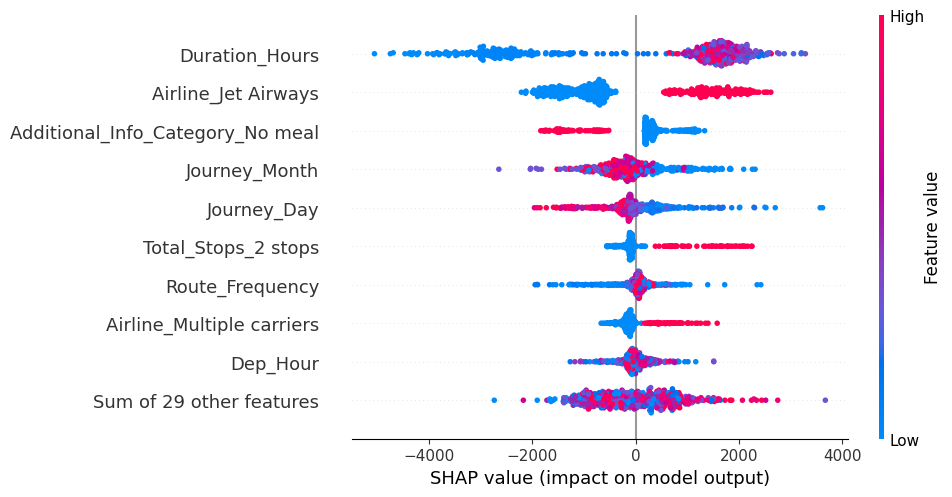

In [ ]:
explainer = shap.Explainer(best_model)
shap_values = explainer(shap_sample)
shap.plots.beeswarm(shap_values)

### SHAP Waterfall Plot - Analysis of Highest Error Prediction

In [ ]:
test_shap_values = explainer(X_test)

In [ ]:
max_id = rel_res[rel_res==rel_res.max()].index[0]
pred_series=pd.Series(y_pred_improved,index=rel_res.index)

In [ ]:
X_test.loc[max_id]

,9105
Duration_Hours,12.0
Dep_Hour,22.666667
Arr_Hour,10.666667
Journey_Day,12
Journey_Month,5
Journey_Weekday,6
Is_Night_Flight,True
Is_Peak_Hour,False
Is_Weekend,True
Additional_Info_Category_No info,True


In [ ]:
max_ordinal_id = X_test.index.get_loc(max_id)

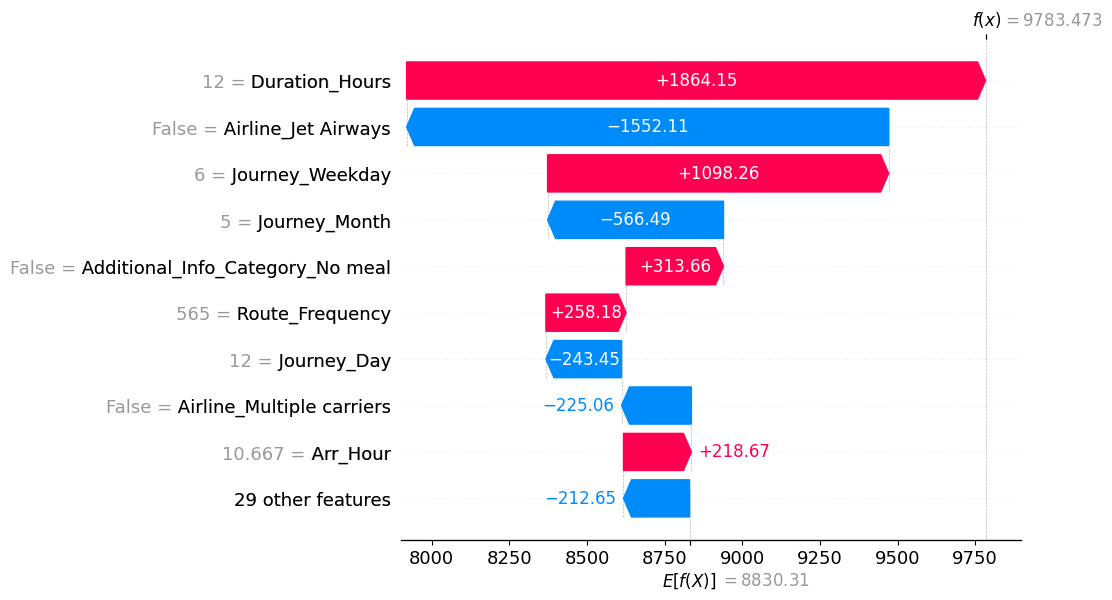

In [ ]:
shap.plots.waterfall(test_shap_values[max_ordinal_id])

### SHAP Beeswarm Plot - Bad Examples Analysis

Threshold for bad examples (99th percentile): 4883.338164062525
Number of bad examples: 21


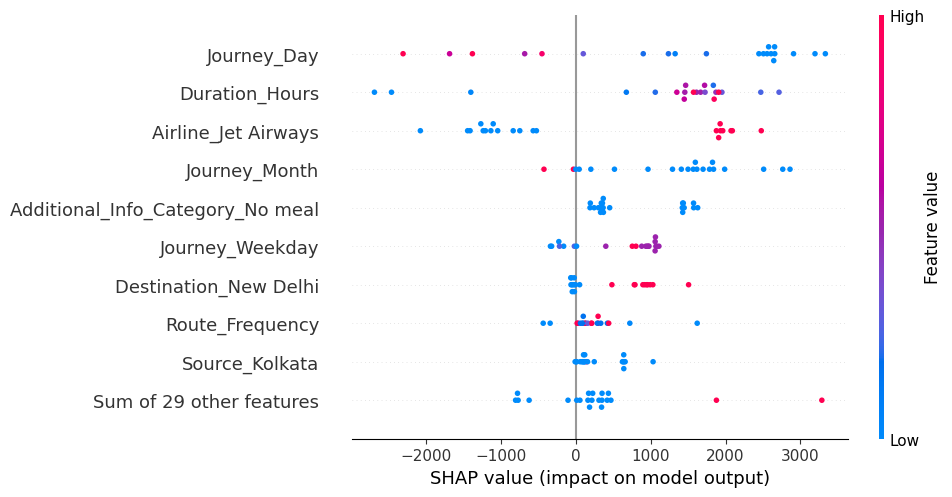

In [ ]:
# Calculate the 99th percentile of residuals
threshold = residuals.quantile(0.99)  # Top 1% of residuals
print(f"Threshold for bad examples (99th percentile): {threshold}")

# Select bad examples
bad_examples = X_test.loc[residuals[residuals > threshold].index]
print(f"Number of bad examples: {len(bad_examples)}")

bad_examples_shap_values = explainer(bad_examples)
shap.plots.beeswarm(bad_examples_shap_values)

### SHAP Analysis Results

The SHAP analysis provides deeper insights into feature contributions:

1. **Feature Impact Direction**:
   - Duration_Hours shows strong positive correlation with price
   - Airline_Jet Airways has significant negative impact
   - Journey timing features (Month, Day, Weekday) show varied impacts

2. **Magnitude of Effects**:
   - Duration not only shows the largest absolute impact (+1864.15) but also displays a wide distribution of SHAP values, emphasizing its crucial role in pricing across all ranges
   - Airline choices can affect prices by up to 1552₹
   - Journey_Weekday shows substantial impact (+1098.26 or -566.49), indicating significant price variations based on specific days
   - Route_Frequency shows a positive impact (+258.18), suggesting that popular routes tend to be slightly more expensive

3. **Complex Interactions**:
   - Multiple features demonstrate bidirectional effects, where the same feature can significantly increase or decrease prices depending on its specific values (notably seen in Duration_Hours, Journey features, Airline categories and Route_Frequency)
   - Temporal features show non-linear relationships with price

4. **Feature Group Impact** (from Both Beeswarm Plots):
   - The "Sum of 29 other features" shows a moderate combined effect (-212.65), confirming that the model correctly identifies the most significant features
   - This indicates that while many features contribute to the prediction, their individual impacts are relatively small compared to the primary drivers

## 3. Model Performance Comparison

### Actual vs Predicted Prices Comparison

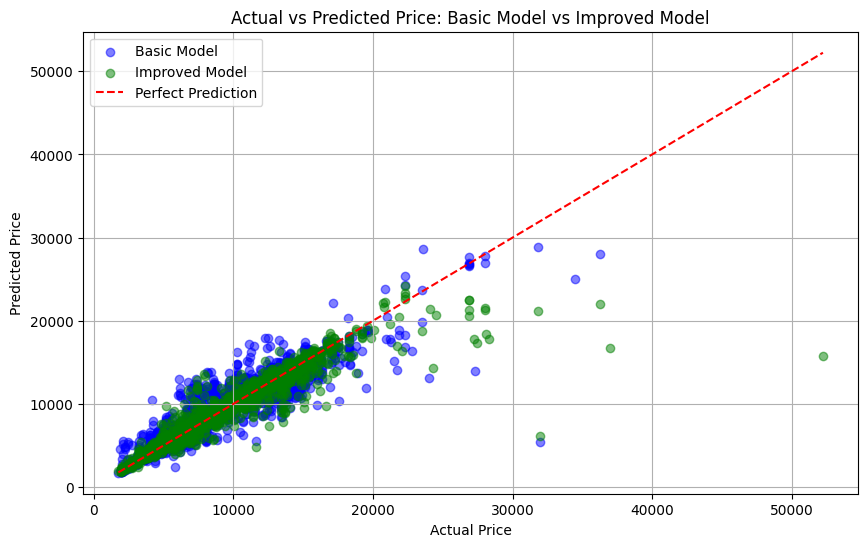

In [ ]:
plt.figure(figsize=(10, 6))

# Scatter plot for the basic model
plt.scatter(y_test_basic, y_pred_basic, alpha=0.5, label='Basic Model', color='blue')

# Scatter plot for the improved model
plt.scatter(y_test, y_pred_improved, alpha=0.5, label='Improved Model', color='green')

# Perfect prediction line
min_price = min(min(y_test_basic), min(y_test))  # Get the lowest price across both datasets
max_price = max(max(y_test_basic), max(y_test))  # Get the highest price across both datasets
plt.plot([min_price, max_price], [min_price, max_price], '--', color='red', label='Perfect Prediction')

plt.title('Actual vs Predicted Price: Basic Model vs Improved Model')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.legend()
plt.grid(True)

plt.show()

### Residual Distribution Comparison

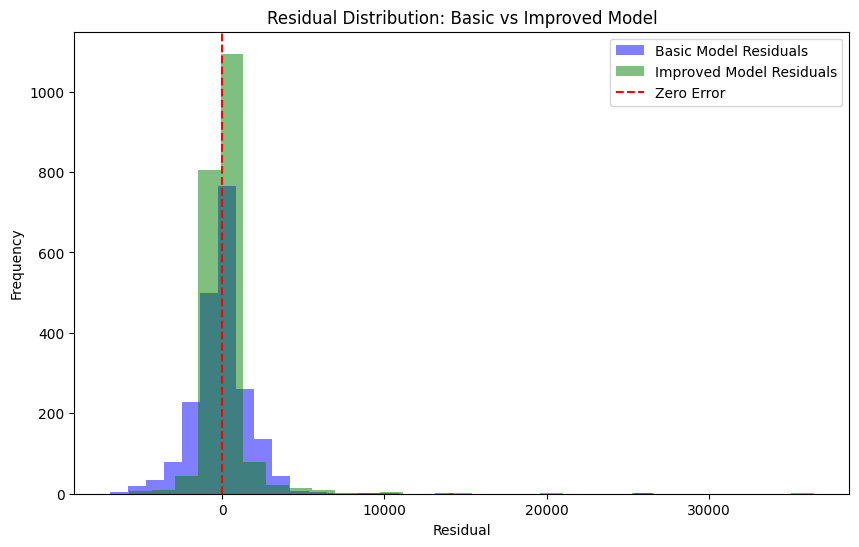

In [ ]:
residuals_basic = y_test_basic - y_pred_basic
residuals_improved = y_test - y_pred_improved

# Residual distribution plot
plt.figure(figsize=(10, 6))
plt.hist(residuals_basic, bins=30, alpha=0.5, label='Basic Model Residuals', color='blue')
plt.hist(residuals_improved, bins=30, alpha=0.5, label='Improved Model Residuals', color='green')
plt.axvline(0, color='red', linestyle='--', label='Zero Error')
plt.title('Residual Distribution: Basic vs Improved Model')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.legend()
plt.show()

### Performance Metrics Comparison

In [ ]:
r2_basic = r2_score(y_test_basic, y_pred_basic)
r2_improved = r2_score(y_test, y_pred_improved)

pearson_corr_basic = stats.pearsonr(y_test_basic, y_pred_basic)[0]
pearson_corr_improved = stats.pearsonr(y_test, y_pred_improved)[0]

rmse_basic = np.sqrt(mean_squared_error(y_test_basic, y_pred_basic))
rmse_improved = np.sqrt(mean_squared_error(y_test, y_pred_improved))

In [ ]:
# Define a threshold for high/low prices
threshold = y_test.median()

# Convert continuous predictions to binary
y_test_binary_basic = (y_test_basic > threshold).astype(int)
y_pred_binary_basic = (y_pred_basic > threshold).astype(int)

y_test_binary_improved = (y_test > threshold).astype(int)
y_pred_binary_improved = (y_pred_improved > threshold).astype(int)

roc_auc_basic = roc_auc_score(y_test_binary_basic, y_pred_basic)
roc_auc_improved = roc_auc_score(y_test_binary_improved, y_pred_improved)

In [ ]:
data = [
    ["R-squared", f"{r2_basic:.2f}", f"{r2_improved:.2f}"],
    ["Pearson Correlation", f"{pearson_corr_basic:.2f}", f"{pearson_corr_improved:.2f}"],
    ["RMSE", f"{rmse_basic:.2f}", f"{rmse_improved:.2f}"],
    ["ROC-AUC", f"{roc_auc_basic:.2f}", f"{roc_auc_improved:.2f}"],
]

# Define column names
headers = ["Metric", "Basic Model", "Improved Model"]

table = tabulate(data, headers=headers, tablefmt="fancy_grid", numalign="center", stralign="center")
print(table)

╒═════════════════════╤═══════════════╤══════════════════╕
│       Metric        │  Basic Model  │  Improved Model  │
╞═════════════════════╪═══════════════╪══════════════════╡
│      R-squared      │     0.84      │       0.88       │
├─────────────────────┼───────────────┼──────────────────┤
│ Pearson Correlation │     0.91      │       0.94       │
├─────────────────────┼───────────────┼──────────────────┤
│        RMSE         │    1793.07    │     1603.26      │
├─────────────────────┼───────────────┼──────────────────┤
│       ROC-AUC       │     0.98      │       0.99       │
╘═════════════════════╧═══════════════╧══════════════════╛


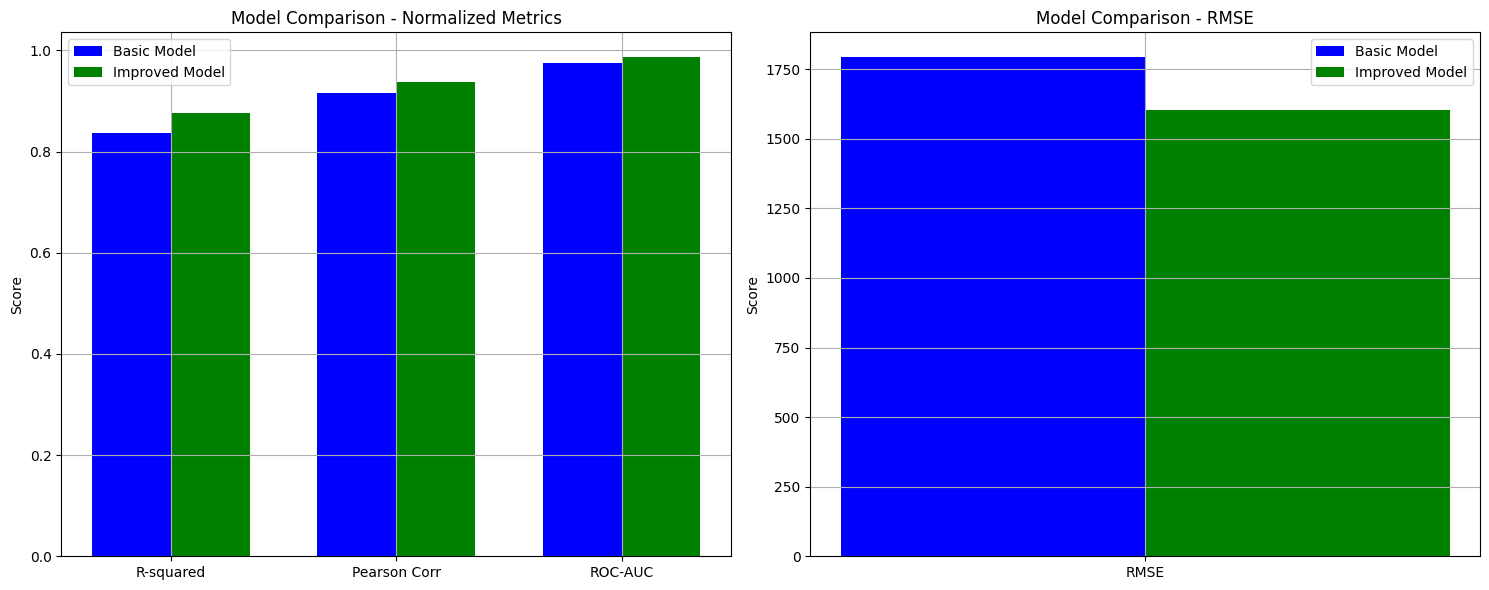

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot metrics with smaller scale (R-squared, Pearson, and ROC-AUC)
metrics_small = ['R-squared', 'Pearson Corr', 'ROC-AUC']
basic_values_small = [r2_basic, pearson_corr_basic, roc_auc_basic]
improved_values_small = [r2_improved, pearson_corr_improved, roc_auc_improved]

x_small = np.arange(len(metrics_small))
width = 0.35

ax1.bar(x_small - width/2, basic_values_small, width, label='Basic Model', color='blue')
ax1.bar(x_small + width/2, improved_values_small, width, label='Improved Model', color='green')
ax1.set_xticks(x_small)
ax1.set_xticklabels(metrics_small)
ax1.set_ylabel('Score')
ax1.set_title('Model Comparison - Normalized Metrics')
ax1.legend()
ax1.grid(True)

# Plot RMSE separately
metrics_large = ['RMSE']
basic_values_large = [rmse_basic]
improved_values_large = [rmse_improved]

x_large = np.arange(len(metrics_large))

ax2.bar(x_large - width/2, basic_values_large, width, label='Basic Model', color='blue')
ax2.bar(x_large + width/2, improved_values_large, width, label='Improved Model', color='green')
ax2.set_xticks(x_large)
ax2.set_xticklabels(metrics_large)
ax2.set_ylabel('Score')
ax2.set_title('Model Comparison - RMSE')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

### Model Performance Comparison

The comparison between the basic and improved models reveals significant enhancements across multiple metrics:

1. **Statistical Metrics Improvement**:
   - R-squared increased from 0.84 to 0.88, indicating better overall fit
   - Pearson Correlation strengthened from 0.91 to 0.94, showing stronger linear relationship between predicted and actual prices
   - RMSE decreased from 1793.07 to 1603.26, representing approximately 10.6% reduction in prediction error
   - ROC-AUC improved slightly from 0.98 to 0.99, suggesting better classification of price ranges

2. **Prediction Accuracy Analysis** (from scatter plot):
   - The improved model shows tighter clustering around the perfect prediction line
   - Better handling of medium-range prices
   - Still some challenges with extreme high prices, though improved from basic model
   - More consistent performance across different price ranges

3. **Error Distribution Improvements** (from residual plot):
   - Residuals are more concentrated around zero in the improved model
   - The distribution is more symmetrical, indicating less bias
   - Smaller spread in residuals, showing more consistent predictions
   - Fewer extreme outliers in predictions

These improvements can be attributed to our enhancement strategies:
- Effective outlier handling using IQR method
- Addition of meaningful engineered features (Route_Frequency, Metro_Stops)
- Successful extraction of information from Additional_Info
- Optimized hyperparameters through systematic tuning
- Balanced representation of different price ranges in training data

# Step 4: Conclusions and Applications

## 1. Key Insights from Model Analysis

### Feature Impact on Flight Pricing
* **Duration and Timing Dominance**: Flight duration and timing (day, hour) are the strongest price determinants, suggesting that airlines primarily base their pricing on these operational factors.
* **Route Characteristics**: Popular routes (high Route_Frequency) tend to be more expensive, possibly due to higher demand. However, the presence of multiple carriers on a route can lead to more competitive pricing.
* **Carrier Impact**: Specific airlines consistently show different pricing patterns, with some carriers (like Jet Airways) significantly affecting prices.

### Identified Patterns and Trends
* **Time-Based Pricing**: Strong temporal patterns in pricing, with significant variations based on:
  - Day of week (weekend vs. weekday differences)
  - Time of day (peak hours vs. off-peak)
  - Seasonal variations (monthly patterns)
* **Route Complexity**: Multi-stop flights show complex pricing patterns, suggesting that airlines use different pricing strategies for direct vs. connecting flights.

### Surprising Findings
* The moderate importance of engineered features (Metro_Stops, Route_Frequency) reveals that market dynamics play a significant role in pricing beyond basic operational factors.
* Additional_Info features showed meaningful impact, validating our decision to process this previously dropped information.

### Model Limitations and Future Improvements
* **Geographic Limitation**: The model is trained exclusively on domestic Indian flights, limiting its applicability to international routes
* **Temporal Constraints**: Our data doesn't account for special events or peak seasons that might affect pricing
* **Feature Coverage**: While our engineered features improved predictions significantly, there's potential to incorporate:
  - Major events and festivals data
  - Tourism seasonality information
  - Competition data on specific routes

## 2. Practical Applications

### For Customers
1. **Travel Planning Tool**:
   - Help users identify optimal booking times
   - Suggest alternative routes or carriers for cost savings
   - Provide price predictions for future travel dates

2. **Cost-Saving Recommendations**:
   - Alert users to typically lower-priced flight options
   - Suggest alternative departure/arrival times for better rates

### For Travel Agencies
1. **Inventory Management**:
   - Better predict price fluctuations for advance bookings
   - Optimize bulk purchase timing

2. **Customer Advisory**:
   - Provide data-driven recommendations for cost-effective travel
   - Better estimate future price changes


## 3. Future Development Opportunities

* Integration with real-time pricing APIs for dynamic predictions
* Expansion to include international routes and more carriers
* Development of a user-friendly interface for price predictions
* Integration with existing travel booking platforms
